## About Dataset
Please note that this is the original dataset with additional information and proper attribution. There is at least one other version of this dataset on Kaggle that was uploaded without permission. Please be fair and attribute the original author.
This synthetic dataset is modeled after an existing milling machine and consists of 10 000 data points from a stored as rows with 14 features in columns

- UID: unique identifier ranging from 1 to 10000
- product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
- type: just the product type L, M or H from column 2
- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
- torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
- tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
- a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.
The machine failure consists of five independent failure modes

- tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
- heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.
- power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
- overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
- random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.
This dataset is part of the following publication, please cite when using this dataset:
S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.

The image of the milling process is the work of Daniel Smyth @ Pexels: https://www.pexels.com/de-de/foto/industrie-herstellung-maschine-werkzeug-10406128/

In [1]:
# Standard Libraries
import warnings

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Libraries
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import (
    RandomizedSearchCV, 
    train_test_split, 
    KFold, 
    cross_validate, 
    cross_val_predict
)
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    roc_auc_score, 
    roc_curve, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score
)

# XGBoost
from xgboost import XGBClassifier, plot_importance

# CatBoost
from catboost import CatBoostClassifier, Pool

# Imbalanced-learn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Hyperparameter Optimization
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Model Persistence
import joblib

# Set Seaborn Style
sns.set_style('white')

# Matplotlib Inline (if using Jupyter Notebook)
%matplotlib inline

# Suppress Warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("/home/jovyan/work/ai4i2020.csv")

## Análise exploratória de dados

In [3]:
df.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    0    0    0    0

In [4]:
df.drop(['UDI','Product ID'],axis=1,inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Machine failure          10000 non-null  int64  
 7   TWF                      10000 non-null  int64  
 8   HDF                      10000 non-null  int64  
 9   PWF                      10000 non-null  int64  
 10  OSF                      10000 non-null  int64  
 11  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 937.6+ KB


In [6]:
df.describe(include='all')

Type  Air temperature [K]  Process temperature [K]  \
count   10000         10000.000000             10000.000000   
unique      3                  NaN                      NaN   
top         L                  NaN                      NaN   
freq     6000                  NaN                      NaN   
mean      NaN           300.004930               310.005560   
std       NaN             2.000259                 1.483734   
min       NaN           295.300000               305.700000   
25%       NaN           298.300000               308.800000   
50%       NaN           300.100000               310.100000   
75%       NaN           301.500000               311.100000   
max       NaN           304.500000               313.800000   

        Rotational speed [rpm]   Torque [Nm]  Tool wear [min]  \
count             10000.000000  10000.000000     10000.000000   
unique                     NaN           NaN              NaN   
top                        NaN           NaN              NaN   
freq                       NaN           NaN              NaN   
mean               1538.776100     39.986910       107.951000   
std                 179.284096      9.968934        63.654147   
min                1168.000000      3.800000         0.000000   
25%                1423.000000     33.200000        53.000000   
50%                1503.000000     40.100000       108.000000   
75%                1612.000000     46.800000       162.000000   
max                2886.000000     76.600000       253.000000   

        Machine failure           TWF           HDF           PWF  \
count      10000.000000  10000.000000  10000.000000  10000.000000   
unique              NaN           NaN           NaN           NaN   
top                 NaN           NaN           NaN           NaN   
freq                NaN           NaN           NaN           NaN   
mean           0.033900      0.004600      0.011500      0.009500   
std            0.180981      0.067671      0.106625      0.097009   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.000000      0.000000      0.000000   
50%            0.000000      0.000000      0.000000      0.000000   
75%            0.000000      0.000000      0.000000      0.000000   
max            1.000000      1.000000      1.000000      1.000000   

                 OSF          RNF  
count   10000.000000  10000.00000  
unique           NaN          NaN  
top              NaN          NaN  
freq             NaN          NaN  
mean        0.009800      0.00190  
std         0.098514      0.04355  
min         0.000000      0.00000  
25%         0.000000      0.00000  
50%         0.000000      0.00000  
75%         0.000000      0.00000  
max         1.000000      1.00000

Há algumas caraterísticas que podemos obter a partir dos dados. 
 - 1. potência (o produto da velocidade de rotação e do binário)
 - 2. potência e desgaste - eu queria dividir os dois, mas o resultado foi infinito nalguns pontos, por isso tentei simplesmente o produto
 - 3. temperatura do processo por potência

In [7]:
df['Power']=df['Rotational speed [rpm]']*df['Torque [Nm]']
df['Power wear']=df['Power']*df['Tool wear [min]']
df['Temperature difference'] = df['Process temperature [K]']-df['Air temperature [K]']
df['Temperature power'] = df['Temperature difference'].astype(float)/df['Power'].astype(float)

In [8]:
df.describe(include='all')

Type  Air temperature [K]  Process temperature [K]  \
count   10000         10000.000000             10000.000000   
unique      3                  NaN                      NaN   
top         L                  NaN                      NaN   
freq     6000                  NaN                      NaN   
mean      NaN           300.004930               310.005560   
std       NaN             2.000259                 1.483734   
min       NaN           295.300000               305.700000   
25%       NaN           298.300000               308.800000   
50%       NaN           300.100000               310.100000   
75%       NaN           301.500000               311.100000   
max       NaN           304.500000               313.800000   

        Rotational speed [rpm]   Torque [Nm]  Tool wear [min]  \
count             10000.000000  10000.000000     10000.000000   
unique                     NaN           NaN              NaN   
top                        NaN           NaN              NaN   
freq                       NaN           NaN              NaN   
mean               1538.776100     39.986910       107.951000   
std                 179.284096      9.968934        63.654147   
min                1168.000000      3.800000         0.000000   
25%                1423.000000     33.200000        53.000000   
50%                1503.000000     40.100000       108.000000   
75%                1612.000000     46.800000       162.000000   
max                2886.000000     76.600000       253.000000   

        Machine failure           TWF           HDF           PWF  \
count      10000.000000  10000.000000  10000.000000  10000.000000   
unique              NaN           NaN           NaN           NaN   
top                 NaN           NaN           NaN           NaN   
freq                NaN           NaN           NaN           NaN   
mean           0.033900      0.004600      0.011500      0.009500   
std            0.180981      0.067671      0.106625      0.097009   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.000000      0.000000      0.000000   
50%            0.000000      0.000000      0.000000      0.000000   
75%            0.000000      0.000000      0.000000      0.000000   
max            1.000000      1.000000      1.000000      1.000000   

                 OSF          RNF         Power    Power wear  \
count   10000.000000  10000.00000  10000.000000  1.000000e+04   
unique           NaN          NaN           NaN           NaN   
top              NaN          NaN           NaN           NaN   
freq             NaN          NaN           NaN           NaN   
mean        0.009800      0.00190  59967.147040  6.471442e+06   
std         0.098514      0.04355  10193.093881  4.016716e+06   
min         0.000000      0.00000  10966.800000  0.000000e+00   
25%         0.000000      0.00000  53105.400000  3.096389e+06   
50%         0.000000      0.00000  59883.900000  6.287880e+06   
75%         0.000000      0.00000  66873.750000  9.489756e+06   
max         1.000000      1.00000  99980.400000  2.081921e+07   

        Temperature difference  Temperature power  
count             10000.000000       10000.000000  
unique                     NaN                NaN  
top                        NaN                NaN  
freq                       NaN                NaN  
mean                 10.000630           0.000172  
std                   1.001094           0.000038  
min                   7.600000           0.000086  
25%                   9.300000           0.000146  
50%                   9.800000           0.000167  
75%                  11.000000           0.000192  
max                  12.100000           0.000936

### Conversão dos tipos para colunas

In [9]:
df = pd.get_dummies(df, drop_first=True).astype(int)

In [10]:
df.head()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                  298                      308                    1551   
1                  298                      308                    1408   
2                  298                      308                    1498   
3                  298                      308                    1433   
4                  298                      308                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF  \
0           42                0                0    0    0    0    0    0   
1           46                3                0    0    0    0    0    0   
2           49                5                0    0    0    0    0    0   
3           39                7                0    0    0    0    0    0   
4           40                9                0    0    0    0    0    0   

   Power  Power wear  Temperature difference  Temperature power  Type_L  \
0  66382           0                      10                  0       0   
1  65190      195571                      10                  0       1   
2  74001      370006                      10                  0       1   
3  56603      396224                      10                  0       1   
4  56320      506880                      10                  0       1   

   Type_M  
0       1  
1       0  
2       0  
3       0  
4       0

### Observação das distribuições das variáveis

<Figure size 1000x1000 with 0 Axes>

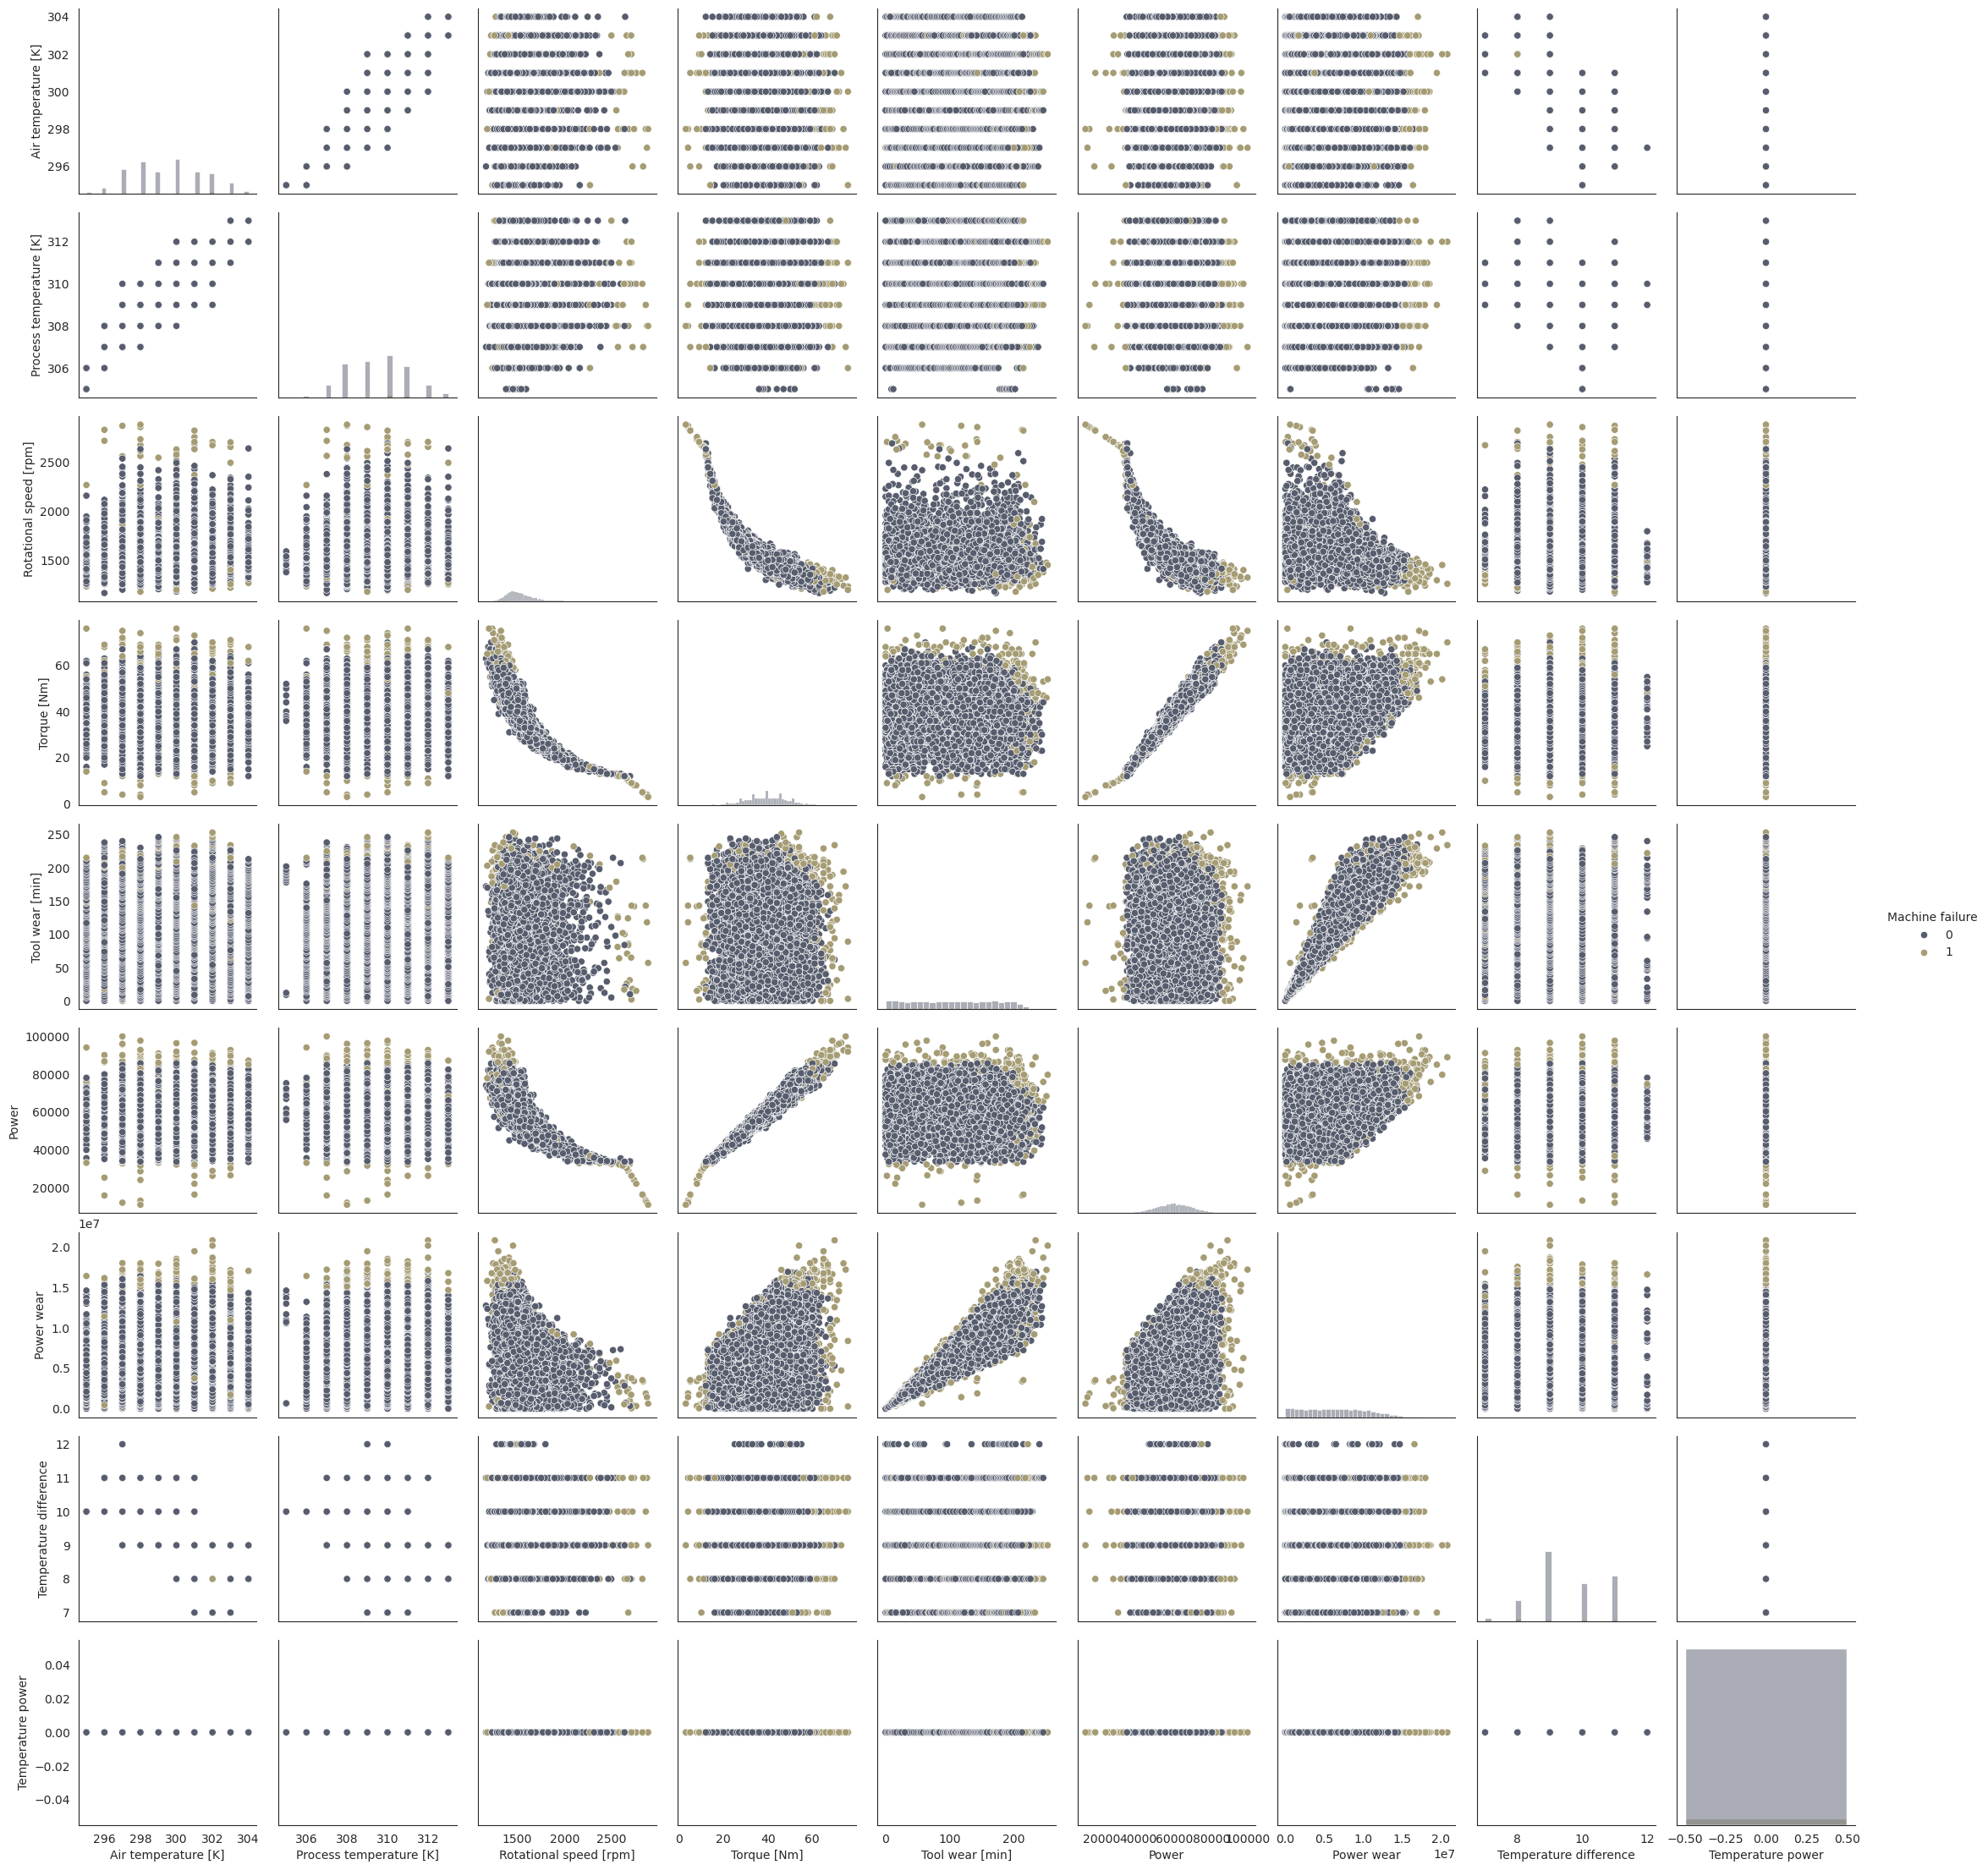

In [11]:
plt.figure(figsize=(10,10))

df_plot = df[['Air temperature [K]',
         'Process temperature [K]',
         'Rotational speed [rpm]',
         'Torque [Nm]',
         'Tool wear [min]',
         'Power',
         'Power wear',
         'Temperature difference',
         'Temperature power',
         'Machine failure'
        ]]
sns.pairplot(
             df_plot,
             diag_kind='hist',
             corner=False,
             palette='cividis',
             hue='Machine failure'
)

plt.show()

O gráfico acima apresenta as seguintes observações:

##### Separação de Classes:

- Os dados de falha da máquina (Machine failure = 1) estão bem menos representados, visíveis como uma pequena proporção nos gráficos.
- Pode ser difícil identificar padrões claros devido ao desbalanceamento significativo.

##### Relações Visíveis:

- Algumas relações entre variáveis são evidentes, como a correlação negativa entre Torque [Nm] e Rotational speed [rpm].
- O desgaste da ferramenta (Tool wear [min]) apresenta leve separação entre os grupos com e sem falha.
##### Densidade em Histogramas:

- Os histogramas diagonais confirmam que as variáveis contínuas têm distribuições específicas e bem definidas, com algumas assimetrias.

#### Corelação

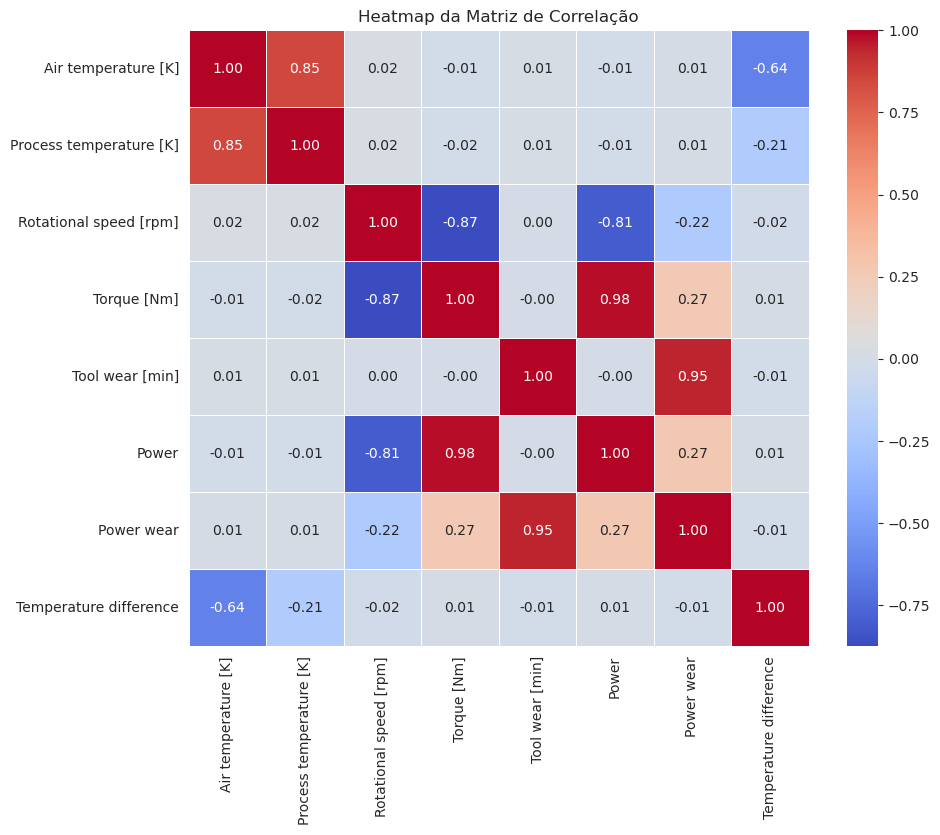

In [12]:
correlation_matrix = df[['Air temperature [K]',
         'Process temperature [K]',
         'Rotational speed [rpm]',
         'Torque [Nm]',
         'Tool wear [min]',
         'Power',
         'Power wear',
         'Temperature difference'
        ]].corr()

# Plotando um heatmap para visualização
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap da Matriz de Correlação')
plt.show()

Observações da Correlação:
##### Relações Fortes:

Existe uma forte correlação positiva entre Air temperature [K] e Process temperature [K] (0.85). Isso sugere que essas variáveis podem estar relacionadas diretamente ou representar a mesma tendência.
##### Correlação Negativa:

Rotational speed [rpm] e Torque [Nm] têm uma correlação negativa muito forte (-0.87), indicando que máquinas em alta velocidade apresentam menor torque.
##### Outras Relações:

As demais variáveis apresentam correlações fracas entre si ou são dependentes uma da outra (Foram geradas a partir da extração das features)

#### Avaliação das labels

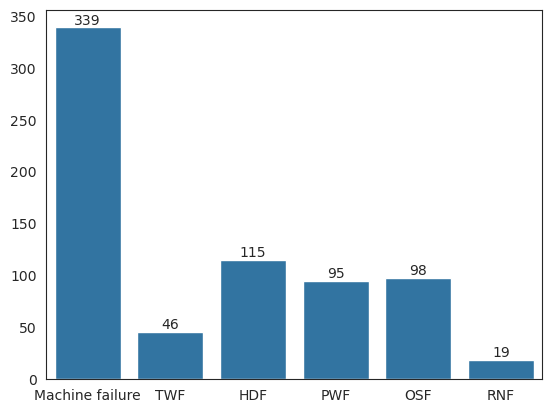

In [13]:
features = ['Air temperature [K]',
         'Process temperature [K]',
         'Rotational speed [rpm]',
         'Torque [Nm]',
         'Tool wear [min]',
         'Power',
         'Power wear',
         'Temperature difference',
         'Temperature power']
labels = ['Machine failure', 'TWF','HDF','PWF','OSF','RNF']

ax = sns.barplot(df[labels].sum())
ax.bar_label(ax.containers[0], fontsize=10);
plt.show()

##### Machine failure:

Existem 339 registros de falha entre 10.000 dados (~3.39%), indicando forte desbalanceamento.
##### Subcategorias de Falha:

- HDF (Hydraulic Failure): Mais frequente, com 115 ocorrências.
- RNF (Random Failures): Menos frequente, com apenas 19 casos.
- As outras categorias (TWF, PWF, OSF) têm ocorrências moderadas (46-98 casos).

## Treinamento dos modelos

Percebe-se que temos muitos dados que mostram falhas, porém são muito desbalanceados, vamos validar se fazendo um oversampling destes dados temos resultados melhores (Ponderando o overfitting)

Para isso vamos testar dois cenários: Manter o dataset original e criar outro dataset com oversampling

### Buscando melhores parâmetros com RandomizedSearchCV e XGB

In [14]:
X = df[features]
y = df[labels]

In [15]:
X.columns = list(map(lambda x: x.replace('[','').replace(']','').replace(' ','_').upper(),X.columns))

In [16]:
clf = MultiOutputClassifier(())

params = {
    "estimator__learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
    "estimator__max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
    "estimator__min_child_weight" : [ 1, 3, 5, 7 ],
    "estimator__gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "estimator__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

xgb = XGBClassifier(objective='binary:logistic')

multi_clf = MultiOutputClassifier(xgb)

clf = RandomizedSearchCV(multi_clf, params, cv=5, return_train_score=True, n_iter=50)

clf.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                                           booster=None,
                                                                           callbacks=None,
                                                                           colsample_bylevel=None,
                                                                           colsample_bynode=None,
                                                                           colsample_bytree=None,
                                                                           device=None,
                                                                           early_stopping_rounds=None,
                                                                           enable_categorical=False,
                                                                           eval_metric=None,
                                                                           feature_types=None,
                                                                           gamma=None,
                                                                           grow_policy=None,
                                                                           importance_type=None,
                                                                           interactio...
                                                                           n_estimators=None,
                                                                           n_jobs=None,
                                                                           num_parallel_tree=None,
                                                                           random_state=None, ...)),
                   n_iter=50,
                   param_distributions={'estimator__colsample_bytree': [0.3,
                                                                        0.4,
                                                                        0.5,
                                                                        0.7],
                                        'estimator__gamma': [0.0, 0.1, 0.2, 0.3,
                                                             0.4],
                                        'estimator__learning_rate': [0.05, 0.1,
                                                                     0.15, 0.2,
                                                                     0.25,
                                                                     0.3],
                                        'estimator__max_depth': [3, 4, 5, 6, 8,
                                                                 10, 12, 15],
                                        'estimator__min_child_weight': [1, 3, 5,
                                                                        7]},
                   return_train_score=True)

In [17]:
print(clf.best_params_)

{'estimator__min_child_weight': 3, 'estimator__max_depth': 15, 'estimator__learning_rate': 0.1, 'estimator__gamma': 0.3, 'estimator__colsample_bytree': 0.4}


### Sem oversampling (Validação cruzada)

In [18]:
xgb = XGBClassifier(
    random_state=42,
    objective='binary:logistic',
    min_child_weight= 1, 
    max_depth=6,
    estimator__learning_rate=0.05,
    estimator__gamma=0.2,
    estimator__colsample_bytree=0.5
)

clf = MultiOutputClassifier(xgb)
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

scores = cross_validate(clf, X, y, cv=k_fold, scoring=scoring)

Accuracy: [0.9745 0.9795 0.972  0.98   0.979 ]
Precision Weighted: [0.70934642 0.77247685 0.69574649 0.6873549  0.78514424]
Recall Weighted: [0.64661654 0.71631206 0.70253165 0.69918699 0.67515924]
F1 Weighted: [0.67237369 0.73785458 0.69573441 0.68986904 0.72151786]


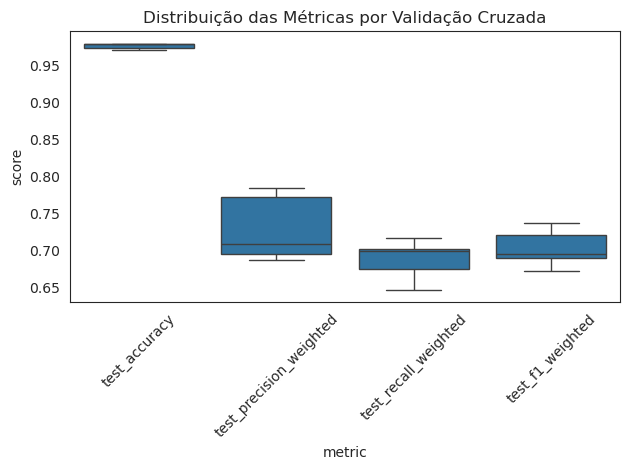

In [19]:
print("Accuracy:", scores['test_accuracy'])
print("Precision Weighted:", scores['test_precision_weighted'])
print("Recall Weighted:", scores['test_recall_weighted'])
print("F1 Weighted:", scores['test_f1_weighted'])

df_scores = pd.DataFrame(scores)

metrics = ['test_accuracy', 'test_precision_weighted', 'test_recall_weighted', 'test_f1_weighted']
df_melted = df_scores[metrics].melt(var_name="metric", value_name="score")

sns.boxplot(x="metric", y="score", data=df_melted)
plt.title("Distribuição das Métricas por Validação Cruzada")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Para interpretar esses resultados, é importante considerar o que cada métrica representa e comparar os valores obtidos em conjunto:

1. **Accuracy (~0.98):**  
   A acurácia está muito alta, indicando que em geral o modelo está classificando corretamente a maioria dos exemplos. No entanto, uma alta acurácia pode ser enganosa se o conjunto de dados for desbalanceado, pois o modelo pode estar acertando principalmente a classe majoritária, ignorando a minoria.

2. **Precision Weighted (~0.70 a 0.82):**  
   A precisão (weighted) avalia, das previsões positivas que o modelo fez, quantas estão corretas, ponderando pelas classes. Valores entre 0.70 e 0.82 são moderados, indicando que das classes que o modelo prediz como certas, uma proporção razoável está correta, mas não tão alta quanto a acurácia.

3. **Recall Weighted (~0.60 a 0.80):**  
   O recall ponderado está na faixa de 0.60 a 0.80, variando bastante entre as dobras de cross-validation. O recall avalia quantos dos exemplos de cada classe o modelo conseguiu recuperar. Esse valor menor que a acurácia sugere que o modelo está deixando de detectar corretamente uma parte significativa de uma ou mais classes minoritárias.

4. **F1 Weighted (~0.64 a 0.77):**  
   O F1 ponderado é uma média harmônica entre precisão e recall, ponderada pelas classes. Ele está na faixa de 0.64 a 0.77, ou seja, está intermediário entre a precisão e o recall. Isso indica que o equilíbrio entre os dois não é tão alto quanto a acurácia.

**Conclusão:**  
- O modelo apresenta altíssima acurácia, o que muitas vezes sugere que há um forte desbalanceamento nas classes ou que a maioria dos exemplos pertence a uma classe dominante.
- As métricas ponderadas por classe (precisão, recall, F1) estão mais baixas e variam consideravelmente entre as diferentes partições do conjunto de validação. Isso sugere que o desempenho do modelo nas classes menos frequentes não é tão bom.
- Em um cenário de classes desbalanceadas, é mais informativo olhar para métricas como precisão, recall e F1 ponderados do que somente a acurácia.
- A variação entre as dobras do cross-validation também mostra que o desempenho não é totalmente consistente, o que pode indicar sensibilidade ao conjunto de treinamento.

Em resumo, apesar da elevada acurácia, o modelo pode estar falhando em capturar bem as clVamosm passo a mais seria analisar a matriz de confusão por classe ou utilizar métricas específicas (como F1 por classe) para entender melhor em quais classes o modelo está tendo mais dificuldade.

In [20]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

clf = MultiOutputClassifier(xgb)
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred = cross_val_predict(clf, X, y, cv=k_fold)

outputs = y.columns

for i, label in enumerate(labels):
    print(f"=== Label {label} ===")

    y_true_i = y.iloc[:, i].values
    y_pred_i = y_pred[:, i]

    cm = confusion_matrix(y_true_i, y_pred_i)
    print("Confusion Matrix:")
    print(cm)

    cr = classification_report(y_true_i, y_pred_i)
    print("Classification Report:")
    print(cr)
    print("----------------------------")



=== Label Machine failure ===
Confusion Matrix:
[[9593   68]
 [ 109  230]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9661
           1       0.77      0.68      0.72       339

    accuracy                           0.98     10000
   macro avg       0.88      0.84      0.86     10000
weighted avg       0.98      0.98      0.98     10000

----------------------------
=== Label TWF ===
Confusion Matrix:
[[9941   13]
 [  44    2]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9954
           1       0.13      0.04      0.07        46

    accuracy                           0.99     10000
   macro avg       0.56      0.52      0.53     10000
weighted avg       0.99      0.99      0.99     10000

----------------------------
=== Label HDF ===
Confusion Matrix:
[[9859   26]
 [  19   96]]
Classification Report:
              prec

**Desequilíbrio de Classes**

Os resultados indicam que algumas labels (TWF e RNF) têm classes altamente desbalanceadas, onde a classe 1 (falha) é extremamente rara comparada à classe 0 (sem falha). Isso faz com que o modelo aprenda a sempre prever a classe majoritária, resultando em:

    - Alta acurácia: Porque a maioria das previsões está correta para a classe majoritária.
    - Baixa precisão, recall e F1-score para a classe minoritária: O modelo não consegue identificar corretamente as falhas.
    
**Variação entre as Labels**

Enquanto algumas labels (PWF) têm um desempenho excelente, outras (TWF, RNF) apresentam falhas significativas na identificação das classes positivas. Isso pode ser devido à:

    - Diferente grau de desbalanceamento entre as labels.
    - Complexidade das features para certas falhas.
    - Tamanho limitado das classes minoritárias (por exemplo, apenas 46 instâncias para TWF).

Para interpretar esses resultados, é importante considerar o que cada métrica representa e comparar os valores obtidos em conjunto:

1. **Accuracy (~0.98):**  
   A acurácia está muito alta, indicando que em geral o modelo está classificando corretamente a maioria dos exemplos. No entanto, uma alta acurácia pode ser enganosa se o conjunto de dados for desbalanceado, pois o modelo pode estar acertando principalmente a classe majoritária, ignorando a minoria.

2. **Precision Weighted (~0.70 a 0.82):**  
   A precisão (weighted) avalia, das previsões positivas que o modelo fez, quantas estão corretas, ponderando pelas classes. Valores entre 0.70 e 0.82 são moderados, indicando que das classes que o modelo prediz como certas, uma proporção razoável está correta, mas não tão alta quanto a acurácia.

3. **Recall Weighted (~0.60 a 0.80):**  
   O recall ponderado está na faixa de 0.60 a 0.80, variando bastante entre as dobras de cross-validation. O recall avalia quantos dos exemplos de cada classe o modelo conseguiu recuperar. Esse valor menor que a acurácia sugere que o modelo está deixando de detectar corretamente uma parte significativa de uma ou mais classes minoritárias.

4. **F1 Weighted (~0.64 a 0.77):**  
   O F1 ponderado é uma média harmônica entre precisão e recall, ponderada pelas classes. Ele está na faixa de 0.64 a 0.77, ou seja, está intermediário entre a precisão e o recall. Isso indica que o equilíbrio entre os dois não é tão alto quanto a acurácia.

**Conclusão:**  
- O modelo apresenta altíssima acurácia, o que muitas vezes sugere que há um forte desbalanceamento nas classes ou que a maioria dos exemplos pertence a uma classe dominante.
- As métricas ponderadas por classe (precisão, recall, F1) estão mais baixas e variam consideravelmente entre as diferentes partições do conjunto de validação. Isso sugere que o desempenho do modelo nas classes menos frequentes não é tão bom.
- Em um cenário de classes desbalanceadas, é mais informativo olhar para métricas como precisão, recall e F1 ponderados do que somente a acurácia.
- A variação entre as dobras do cross-validation também mostra que o desempenho não é totalmente consistente, o que pode indicar sensibilidade ao conjunto de treinamento.

Em resumo, apesar da elevada acurácia, o modelo pode estar falhando em capturar bem as clVamosm passo a mais seria analisar a matriz de confusão por classe ou utilizar métricas específicas (como F1 por classe) para entender melhor em quais classes o modelo está tendo mais dificuldade.

### Com oversampling (Split de treino e teste)

##### Com XGBoost

=== Treinamento para o Rótulo: Machine failure ===
Melhores parâmetros para Machine failure: OrderedDict([('classifier__colsample_bytree', 0.4854888511397502), ('classifier__gamma', 0.018350691513884868), ('classifier__learning_rate', 0.13676234547260738), ('classifier__max_depth', 7), ('classifier__min_child_weight', 1)])

Acurácia: 0.9824
Precision: 0.7213
Recall: 0.7857
F1-Score: 0.7521
ROC-AUC: 0.9781
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3188
           1       0.72      0.79      0.75       112

    accuracy                           0.98      3300
   macro avg       0.86      0.89      0.87      3300
weighted avg       0.98      0.98      0.98      3300

--------------------------------------------------


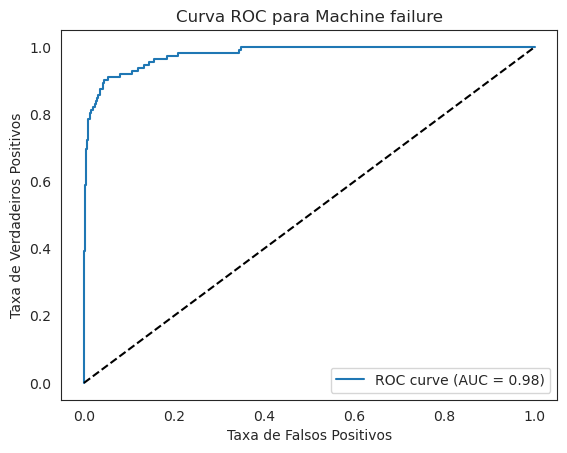

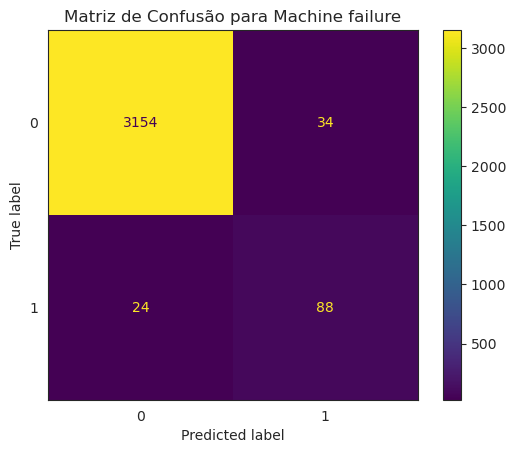

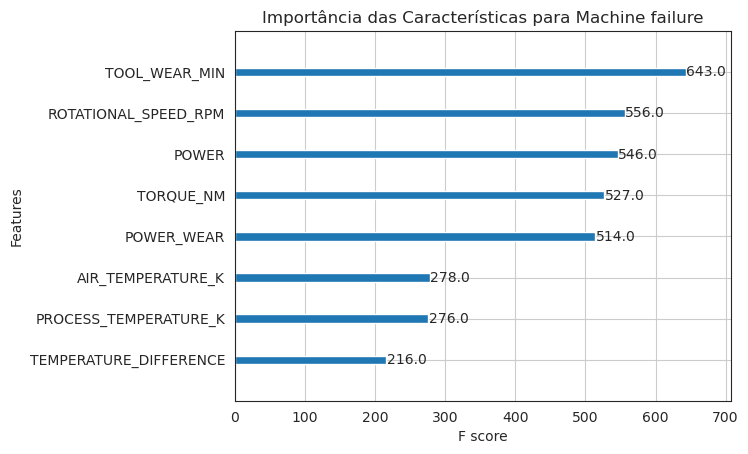

=== Treinamento para o Rótulo: TWF ===
Melhores parâmetros para TWF: OrderedDict([('classifier__colsample_bytree', 0.3), ('classifier__gamma', 0.0), ('classifier__learning_rate', 0.068844844599199), ('classifier__max_depth', 15), ('classifier__min_child_weight', 1)])

Acurácia: 0.9948
Precision: 0.2500
Recall: 0.0667
F1-Score: 0.1053
ROC-AUC: 0.9125
Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3285
           1       0.25      0.07      0.11        15

    accuracy                           0.99      3300
   macro avg       0.62      0.53      0.55      3300
weighted avg       0.99      0.99      0.99      3300

--------------------------------------------------


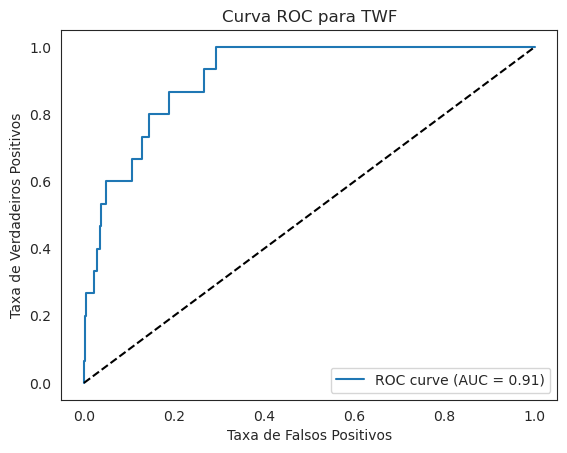

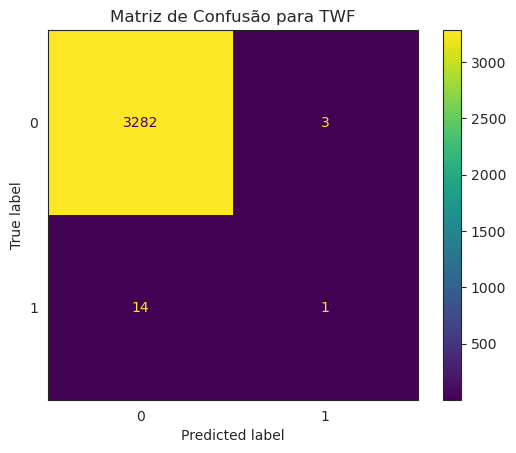

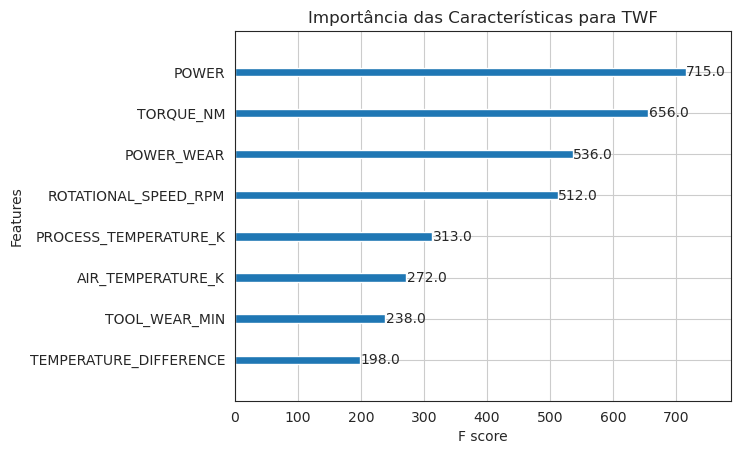

=== Treinamento para o Rótulo: HDF ===
Melhores parâmetros para HDF: OrderedDict([('classifier__colsample_bytree', 0.7), ('classifier__gamma', 0.39396837927337147), ('classifier__learning_rate', 0.10449679928856571), ('classifier__max_depth', 7), ('classifier__min_child_weight', 1)])

Acurácia: 0.9948
Precision: 0.7333
Recall: 0.8684
F1-Score: 0.7952
ROC-AUC: 0.9985
Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3262
           1       0.73      0.87      0.80        38

    accuracy                           0.99      3300
   macro avg       0.87      0.93      0.90      3300
weighted avg       1.00      0.99      1.00      3300

--------------------------------------------------


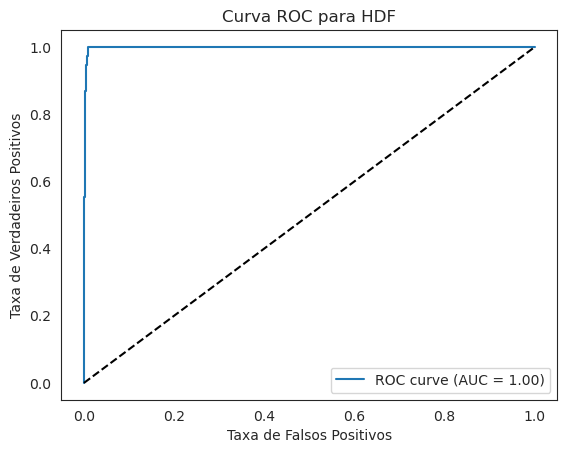

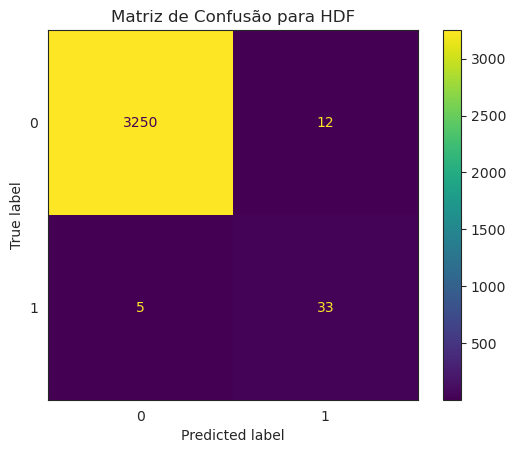

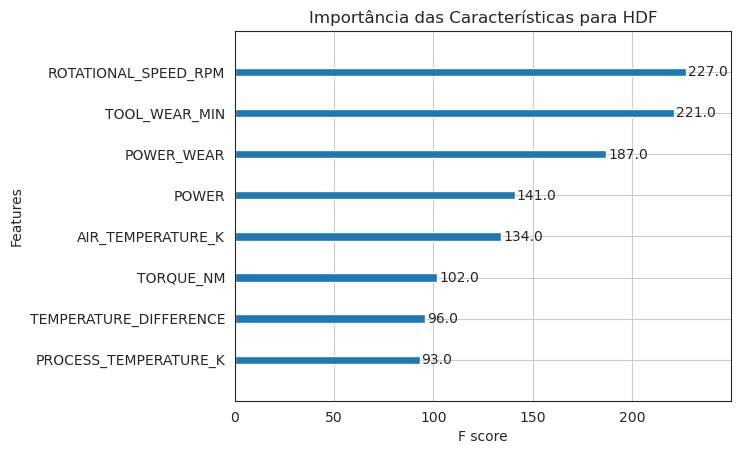

=== Treinamento para o Rótulo: PWF ===
Melhores parâmetros para PWF: OrderedDict([('classifier__colsample_bytree', 0.7), ('classifier__gamma', 0.34042777797285484), ('classifier__learning_rate', 0.13348724488515068), ('classifier__max_depth', 3), ('classifier__min_child_weight', 1)])

Acurácia: 0.9991
Precision: 0.9118
Recall: 1.0000
F1-Score: 0.9538
ROC-AUC: 1.0000
Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3269
           1       0.91      1.00      0.95        31

    accuracy                           1.00      3300
   macro avg       0.96      1.00      0.98      3300
weighted avg       1.00      1.00      1.00      3300

--------------------------------------------------


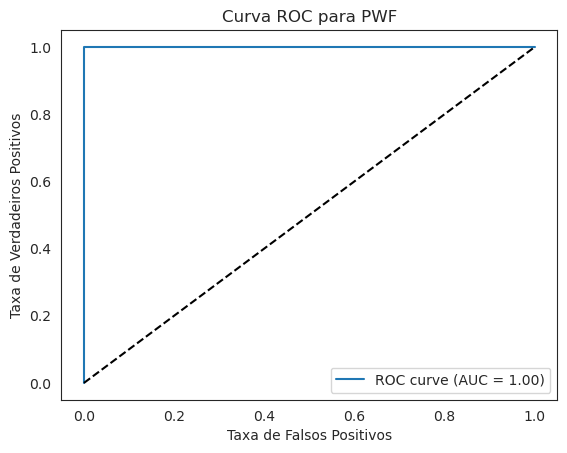

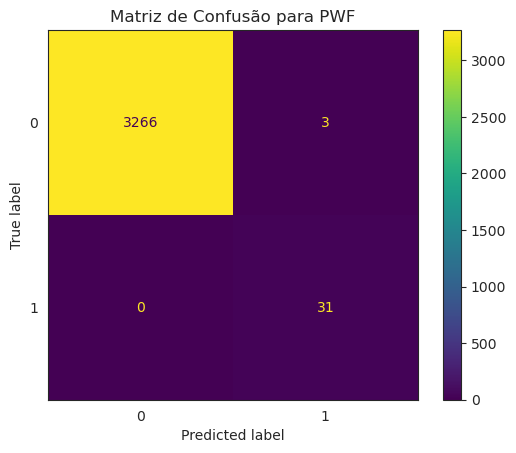

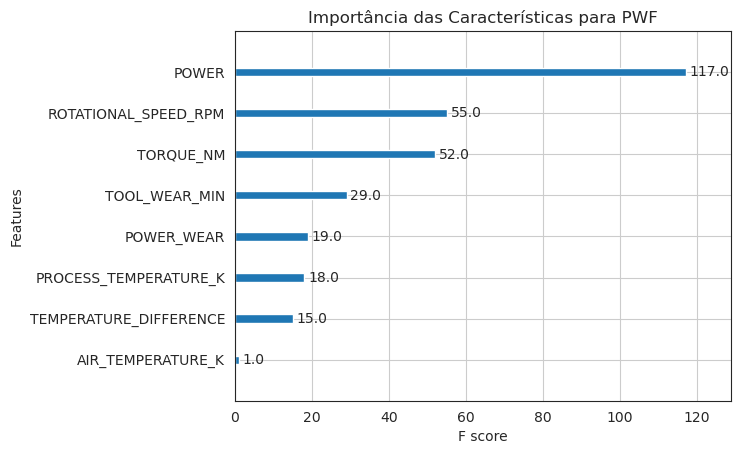

=== Treinamento para o Rótulo: OSF ===
Melhores parâmetros para OSF: OrderedDict([('classifier__colsample_bytree', 0.6663747654275775), ('classifier__gamma', 0.36067861024311065), ('classifier__learning_rate', 0.2684603682415051), ('classifier__max_depth', 3), ('classifier__min_child_weight', 7)])

Acurácia: 0.9973
Precision: 0.7949
Recall: 0.9688
F1-Score: 0.8732
ROC-AUC: 0.9992
Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3268
           1       0.79      0.97      0.87        32

    accuracy                           1.00      3300
   macro avg       0.90      0.98      0.94      3300
weighted avg       1.00      1.00      1.00      3300

--------------------------------------------------


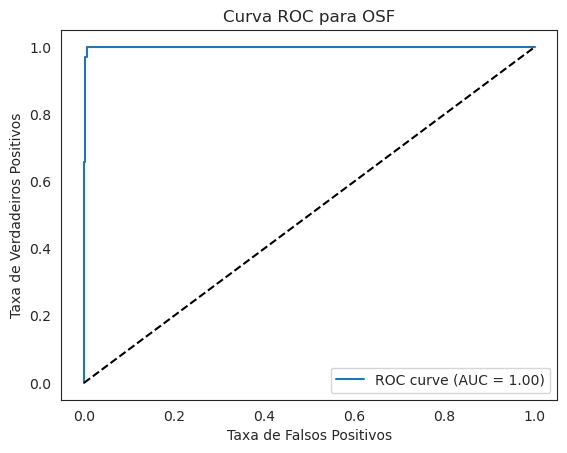

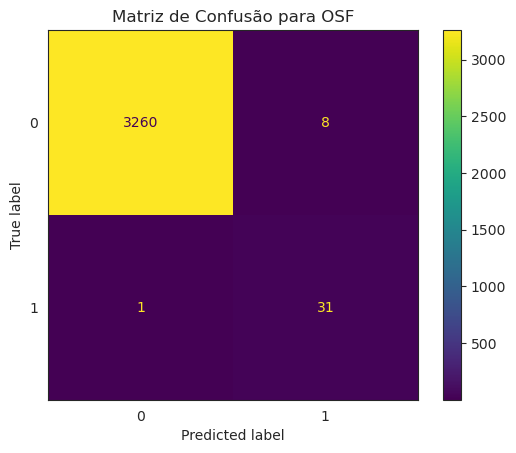

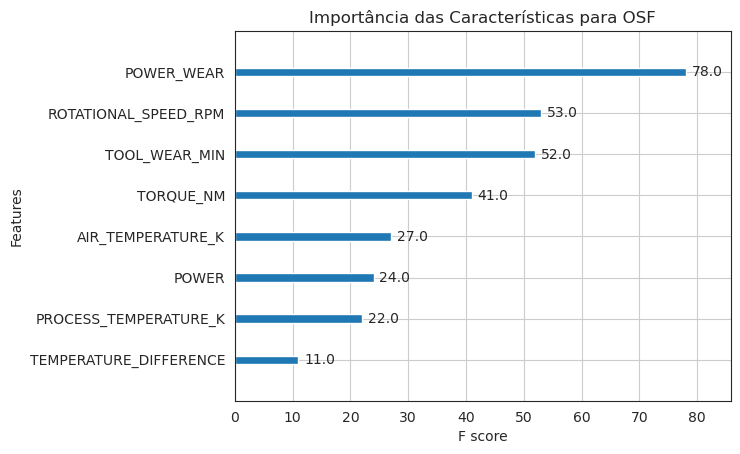

=== Treinamento para o Rótulo: RNF ===
Melhores parâmetros para RNF: OrderedDict([('classifier__colsample_bytree', 0.38807723297062), ('classifier__gamma', 0.00488079729676212), ('classifier__learning_rate', 0.08582190272700295), ('classifier__max_depth', 11), ('classifier__min_child_weight', 1)])

Acurácia: 0.9982
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC-AUC: 0.5413
Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3294
           1       0.00      0.00      0.00         6

    accuracy                           1.00      3300
   macro avg       0.50      0.50      0.50      3300
weighted avg       1.00      1.00      1.00      3300

--------------------------------------------------


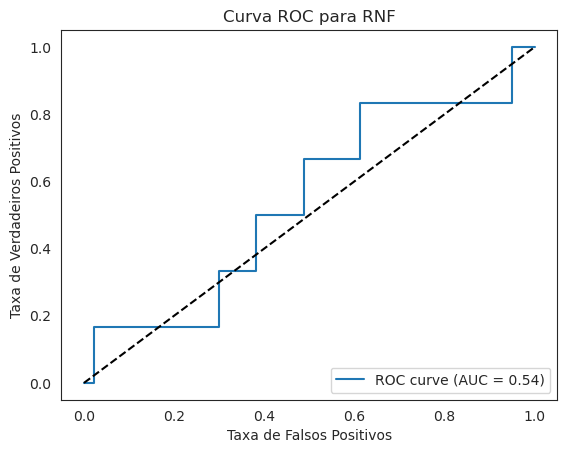

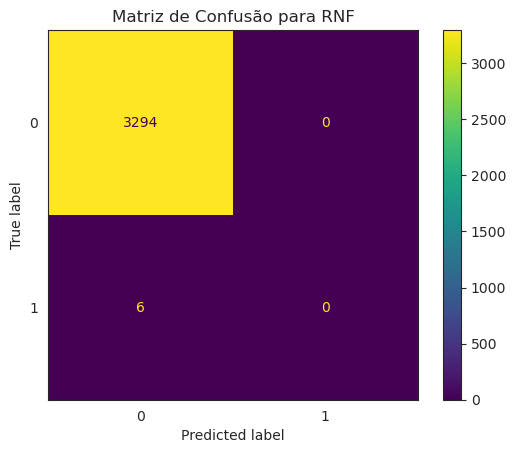

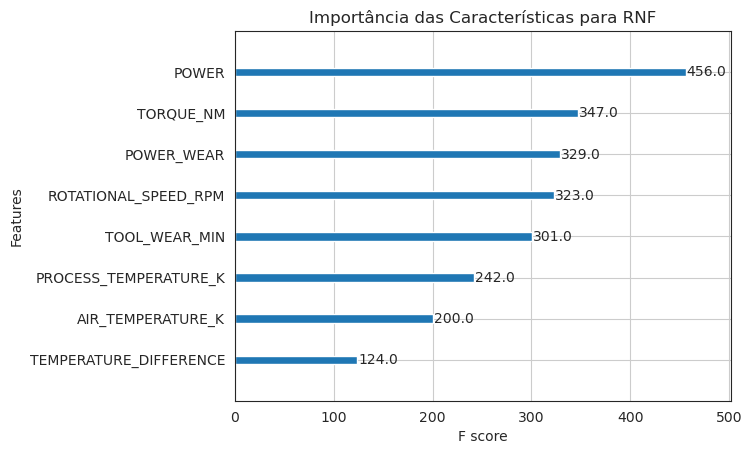

In [21]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    roc_auc_score, 
    roc_curve, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score
)
from xgboost import XGBClassifier, plot_importance
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import numpy as np

X.columns = list(map(lambda x: x.replace('[','').replace(']','').replace(' ','_').upper(), X.columns))

X_y = {}
best_params = {}
trained_models = {}
evaluation_results = {}

for label in labels:
    print(f"=== Treinamento para o Rótulo: {label} ===")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y[label], test_size=0.33, random_state=42, stratify=y[label]
    )
    
    X_y[label] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }
    
    pipeline = Pipeline([
        ('oversample', RandomOverSampler(random_state=0)),
        ('classifier', XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'))
    ])
    
    search_spaces = {
        'classifier__learning_rate': Real(0.05, 0.30, prior='log-uniform'),
        'classifier__max_depth': Integer(3, 15),
        'classifier__min_child_weight': Integer(1, 7),
        'classifier__gamma': Real(0.0, 0.4, prior='uniform'),
        'classifier__colsample_bytree': Real(0.3, 0.7, prior='uniform')
    }
    
    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=search_spaces,
        cv=5,
        n_iter=50,
        scoring='f1_weighted',
        random_state=42,
        verbose=0,
        n_jobs=-1,
        return_train_score=True
    )
    
    bayes_search.fit(X_train, y_train)
    
    best_params[label] = bayes_search.best_params_
    trained_models[label] = bayes_search.best_estimator_
    
    print(f"Melhores parâmetros para {label}: {bayes_search.best_params_}\n")
    
    y_pred = bayes_search.predict(X_test)
    y_proba = bayes_search.predict_proba(X_test)[:, 1]  # Probabilidades para ROC-AUC
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    report = classification_report(y_test, y_pred, zero_division=0)
    
    evaluation_results[label] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc_score': roc_auc,
        'classification_report': report
    }
    
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Relatório de Classificação:\n", report)
    print("-" * 50)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(f'Curva ROC para {label}')
    plt.legend(loc="lower right")
    plt.show()
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Matriz de Confusão para {label}')
    plt.show()
    
    model = bayes_search.best_estimator_.named_steps['classifier']
    plot_importance(model, max_num_features=10)
    plt.title(f'Importância das Características para {label}')
    plt.show()
    
    joblib.dump(bayes_search.best_estimator_, f'models/xgb_model_{label}.joblib')

In [22]:
params_df = pd.DataFrame(best_params).T
params_df.index.name = 'Label'
print("Melhores Parâmetros por Rótulo:")
print(params_df)

evaluation_data = []
for label, metrics in evaluation_results.items():
    evaluation_data.append({
        'Label': label,
        'Acurácia': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1_score'],
        'ROC_AUC': metrics['roc_auc_score']
    })

evaluation_df = pd.DataFrame(evaluation_data)
print("\nResultados de Avaliação por Rótulo:")
print(evaluation_df)

Melhores Parâmetros por Rótulo:
                 classifier__colsample_bytree  classifier__gamma  \
Label                                                              
Machine failure                      0.485489           0.018351   
TWF                                  0.300000           0.000000   
HDF                                  0.700000           0.393968   
PWF                                  0.700000           0.340428   
OSF                                  0.666375           0.360679   
RNF                                  0.388077           0.004881   

                 classifier__learning_rate  classifier__max_depth  \
Label                                                               
Machine failure                   0.136762                    7.0   
TWF                               0.068845                   15.0   
HDF                               0.104497                    7.0   
PWF                               0.133487                    3.0   
OSF      

##### Com CatBoost

=== Treinamento para o Rótulo: Machine failure ===
Modelo treinado para Machine failure.

Acurácia: 0.9842
Precisão: 0.7586
Recall: 0.7857
F1-Score: 0.7719
ROC-AUC: 0.9728
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3188
           1       0.76      0.79      0.77       112

    accuracy                           0.98      3300
   macro avg       0.88      0.89      0.88      3300
weighted avg       0.98      0.98      0.98      3300

--------------------------------------------------


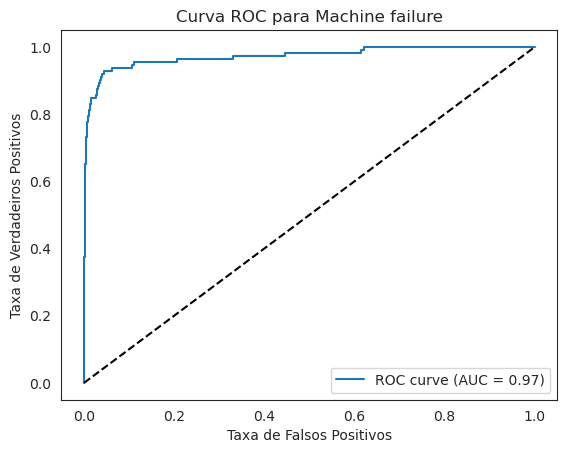

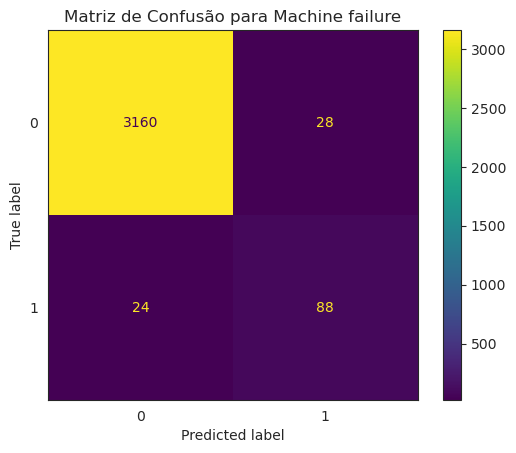

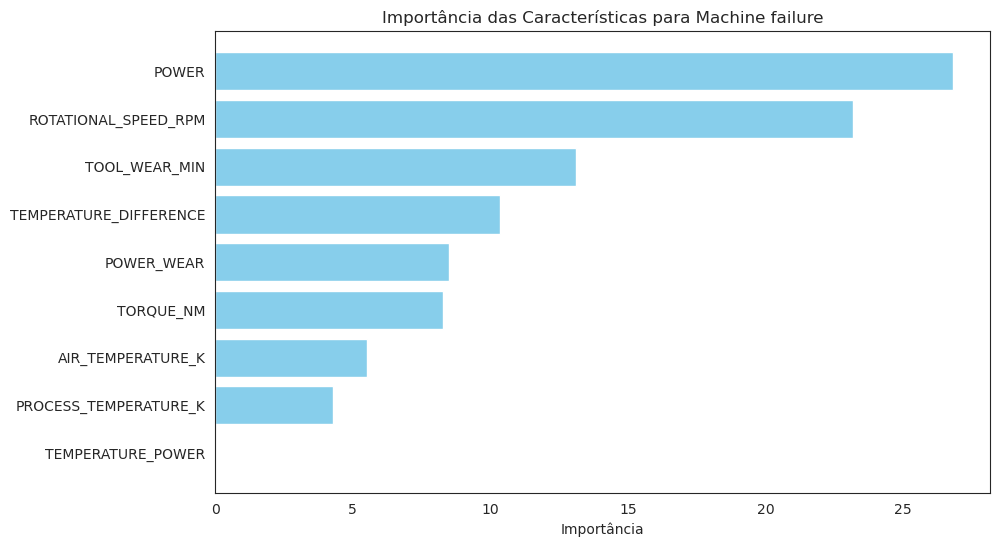

=== Treinamento para o Rótulo: TWF ===
Modelo treinado para TWF.

Acurácia: 0.9894
Precisão: 0.0833
Recall: 0.1333
F1-Score: 0.1026
ROC-AUC: 0.9660
Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      3285
           1       0.08      0.13      0.10        15

    accuracy                           0.99      3300
   macro avg       0.54      0.56      0.55      3300
weighted avg       0.99      0.99      0.99      3300

--------------------------------------------------


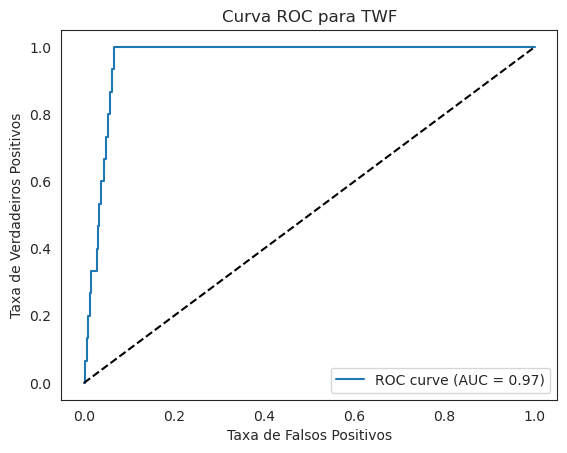

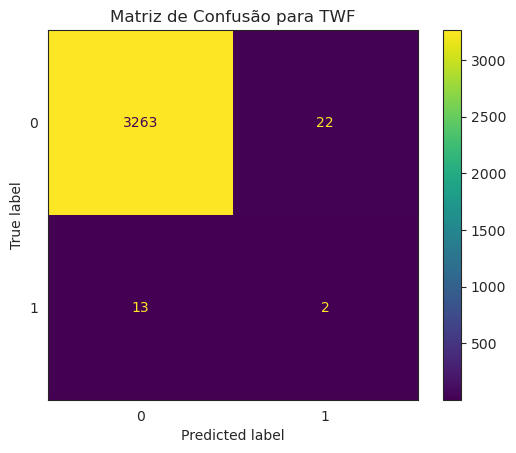

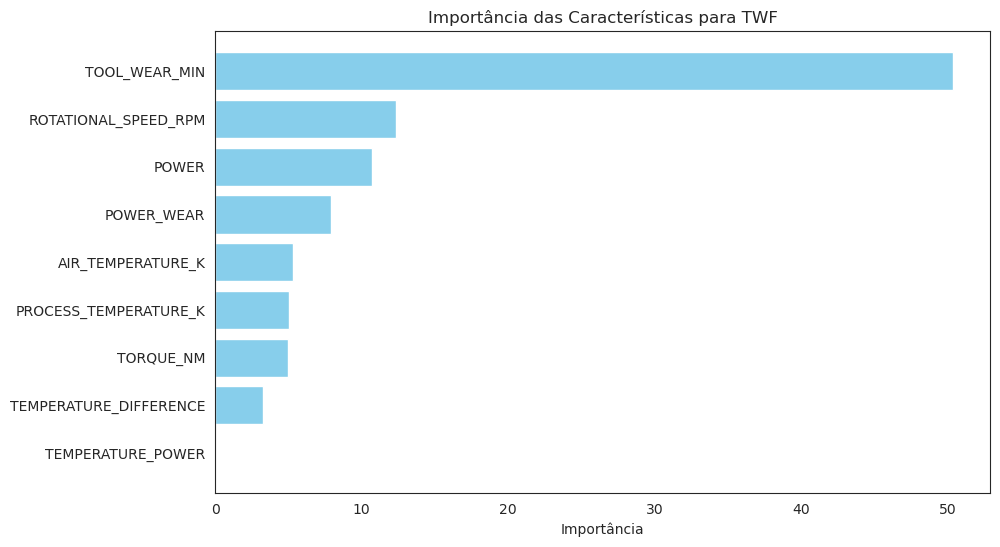

=== Treinamento para o Rótulo: HDF ===
Modelo treinado para HDF.

Acurácia: 0.9927
Precisão: 0.6400
Recall: 0.8421
F1-Score: 0.7273
ROC-AUC: 0.9976
Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      3262
           1       0.64      0.84      0.73        38

    accuracy                           0.99      3300
   macro avg       0.82      0.92      0.86      3300
weighted avg       0.99      0.99      0.99      3300

--------------------------------------------------


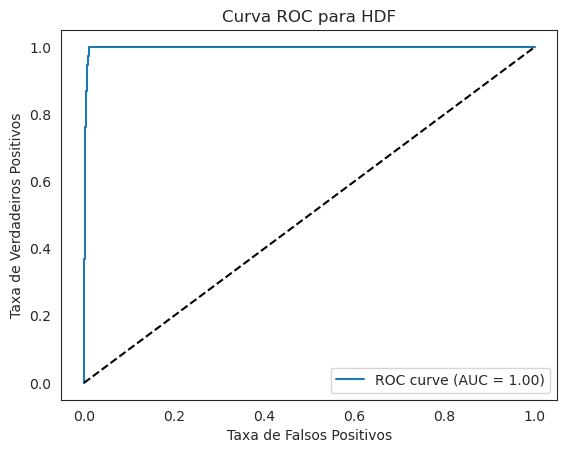

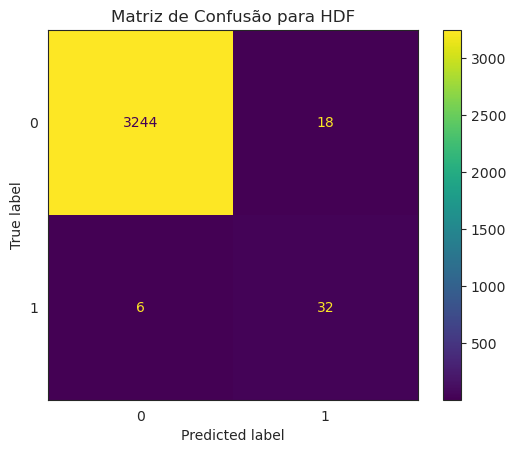

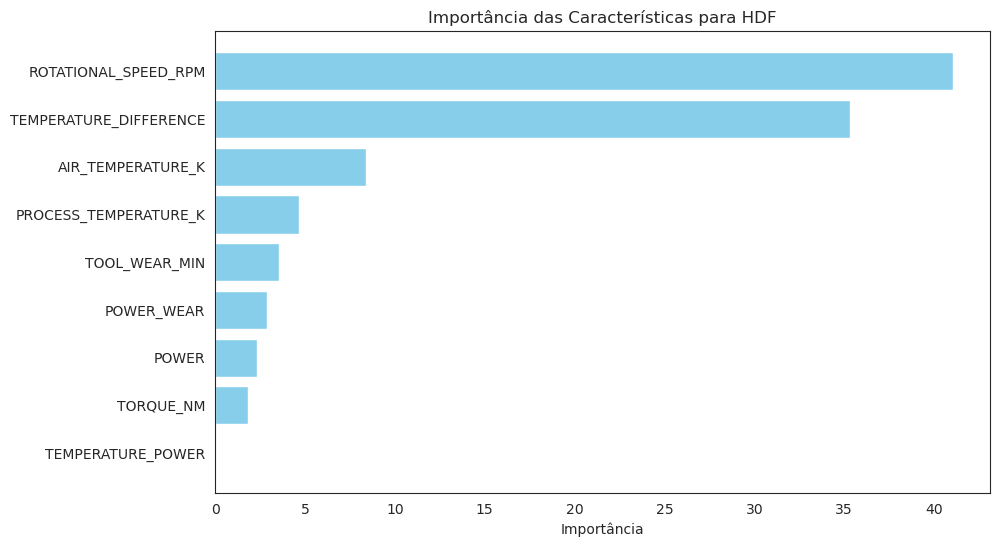

=== Treinamento para o Rótulo: PWF ===
Modelo treinado para PWF.

Acurácia: 0.9997
Precisão: 0.9688
Recall: 1.0000
F1-Score: 0.9841
ROC-AUC: 1.0000
Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3269
           1       0.97      1.00      0.98        31

    accuracy                           1.00      3300
   macro avg       0.98      1.00      0.99      3300
weighted avg       1.00      1.00      1.00      3300

--------------------------------------------------


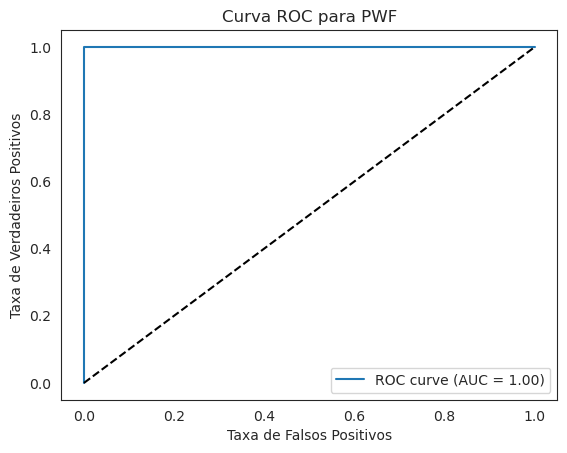

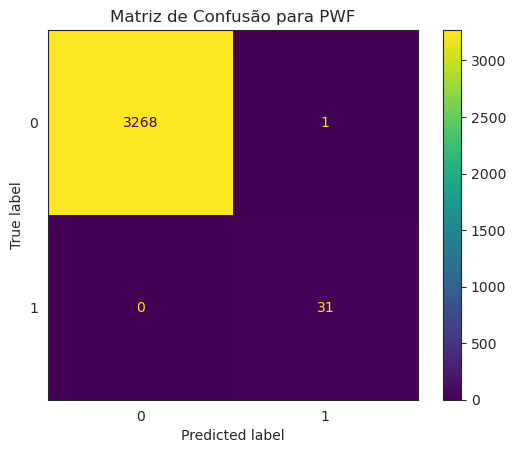

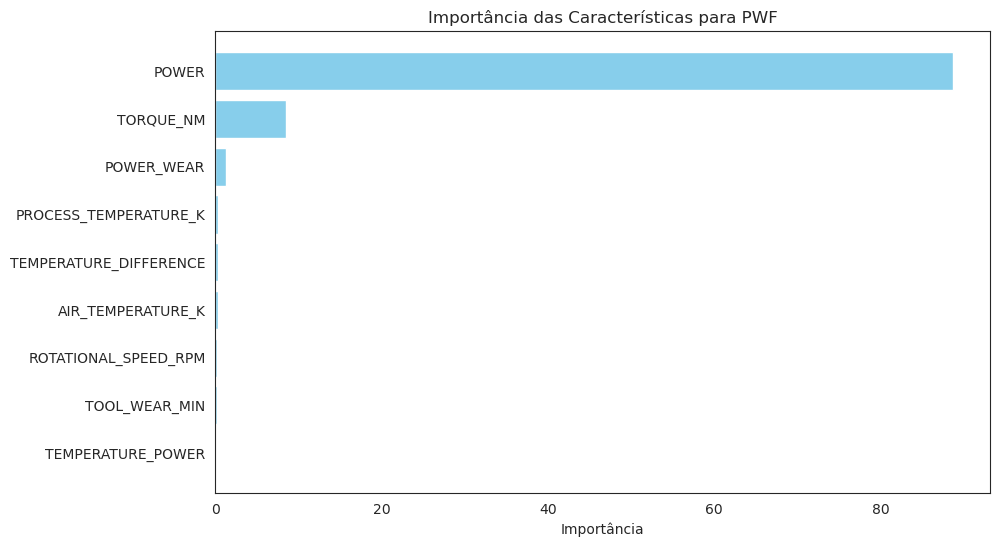

=== Treinamento para o Rótulo: OSF ===
Modelo treinado para OSF.

Acurácia: 0.9964
Precisão: 0.7778
Recall: 0.8750
F1-Score: 0.8235
ROC-AUC: 0.9991
Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3268
           1       0.78      0.88      0.82        32

    accuracy                           1.00      3300
   macro avg       0.89      0.94      0.91      3300
weighted avg       1.00      1.00      1.00      3300

--------------------------------------------------


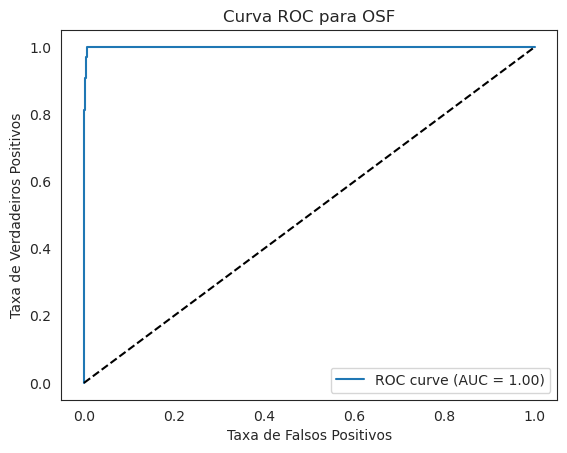

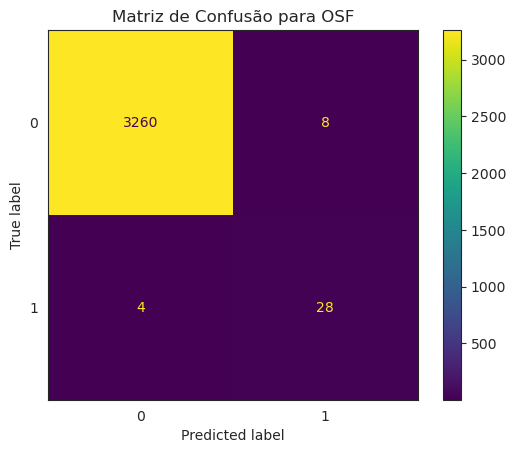

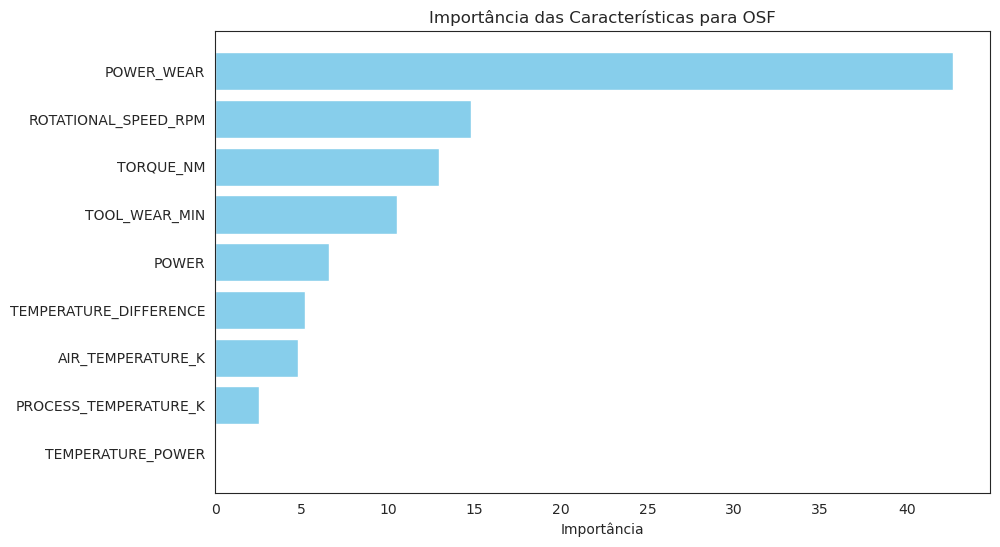

=== Treinamento para o Rótulo: RNF ===
Modelo treinado para RNF.

Acurácia: 0.9976
Precisão: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC-AUC: 0.4126
Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3294
           1       0.00      0.00      0.00         6

    accuracy                           1.00      3300
   macro avg       0.50      0.50      0.50      3300
weighted avg       1.00      1.00      1.00      3300

--------------------------------------------------


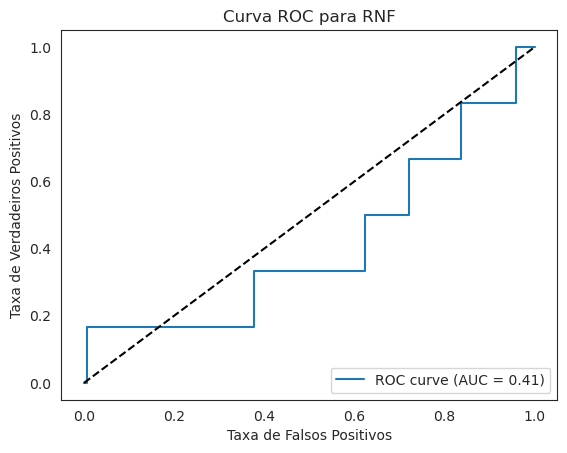

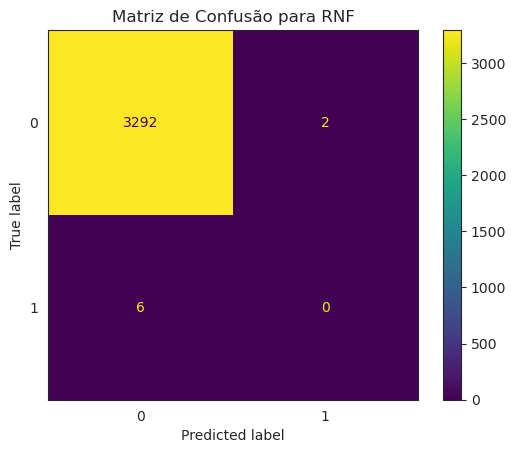

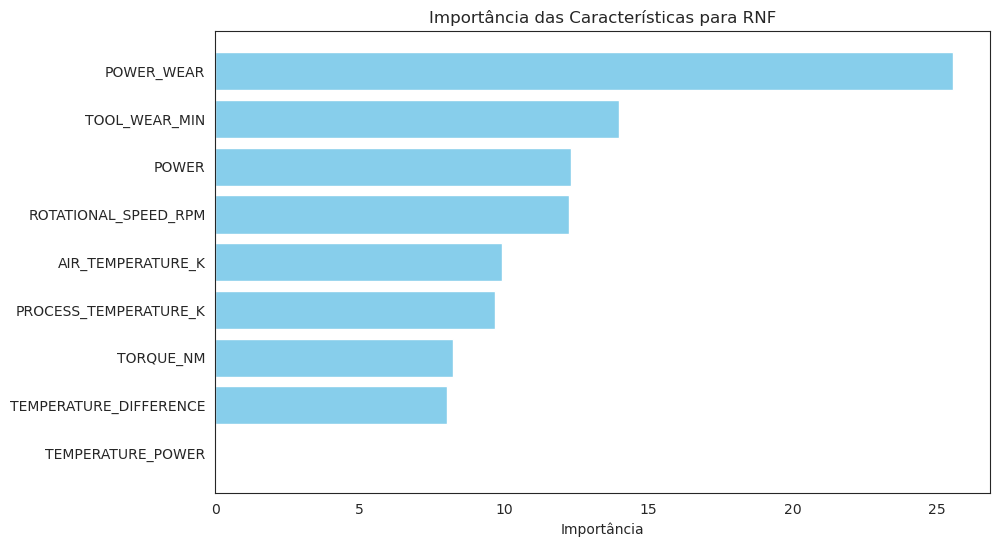

In [23]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    roc_auc_score, 
    roc_curve, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score
)
from catboost import CatBoostClassifier, Pool
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import numpy as np

X.columns = list(map(lambda x: x.replace('[','').replace(']','').replace(' ','_').upper(), X.columns))

X_y = {}
trained_models = {}
evaluation_results = {}

for label in labels:
    print(f"=== Treinamento para o Rótulo: {label} ===")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y[label], test_size=0.33, random_state=42, stratify=y[label]
    )
    
    X_y[label] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }
    
    pipeline = Pipeline([
        ('oversample', RandomOverSampler(random_state=0)),
        ('classifier', CatBoostClassifier(
            iterations=1000,  # Número de árvores
            learning_rate=0.1,  # Taxa de aprendizado
            depth=6,  # Profundidade das árvores
            eval_metric='F1',  # Métrica de avaliação interna
            verbose=0,  # Silenciar a saída do treinamento
            random_state=42
        ))
    ])
    
    pipeline.fit(
        X_train, y_train
    )
    
    trained_models[label] = pipeline
    
    print(f"Modelo treinado para {label}.\n")
    
    y_pred = pipeline.predict(X_test)
    
    if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        roc_auc = None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    report = classification_report(y_test, y_pred, zero_division=0)
    
    evaluation_results[label] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc_score': roc_auc,
        'classification_report': report
    }
    
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.4f}")
    print("Relatório de Classificação:\n", report)
    print("-" * 50)
    
    if roc_auc is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
        plt.xlabel('Taxa de Falsos Positivos')
        plt.ylabel('Taxa de Verdadeiros Positivos')
        plt.title(f'Curva ROC para {label}')
        plt.legend(loc="lower right")
        plt.show()
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Matriz de Confusão para {label}')
    plt.show()
    
    if hasattr(pipeline.named_steps['classifier'], 'get_feature_importance'):
        feature_importances = pipeline.named_steps['classifier'].get_feature_importance()
        feature_names = X_train.columns
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        })
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
        
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1], color='skyblue')
        plt.xlabel('Importância')
        plt.title(f'Importância das Características para {label}')
        plt.show()
    else:
        print(f"O modelo para {label} não possui o método 'get_feature_importance'.")
    
    # Salvando o modelo treinado
    joblib.dump(pipeline, f'models/cat_model_{label}.joblib')


In [24]:
evaluation_data = []
for label, metrics in evaluation_results.items():
    evaluation_data.append({
        'Label': label,
        'Acurácia': metrics['accuracy'],
        'Precisão': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1_score'],
        'ROC_AUC': metrics['roc_auc_score']
    })

evaluation_df = pd.DataFrame(evaluation_data)
print("\nResultados de Avaliação por Rótulo:")
print(evaluation_df)



Resultados de Avaliação por Rótulo:
             Label  Acurácia  Precisão    Recall  F1-Score   ROC_AUC
0  Machine failure  0.984242  0.758621  0.785714  0.771930  0.972822
1              TWF  0.989394  0.083333  0.133333  0.102564  0.965987
2              HDF  0.992727  0.640000  0.842105  0.727273  0.997620
3              PWF  0.999697  0.968750  1.000000  0.984127  1.000000
4              OSF  0.996364  0.777778  0.875000  0.823529  0.999053
5              RNF  0.997576  0.000000  0.000000  0.000000  0.412619


## Avaliação dos resultados

Após realizar os treinamentos com os algoritmos **XGBoost** e **CatBoost**, foram obtidos os seguintes resultados de avaliação para cada rótulo (label):

### **Resultados para Treinamento com XGBoost:**

| Label             | Acurácia | Precision | Recall  | F1-Score | ROC_AUC  |
|-------------------|----------|-----------|---------|----------|----------|
| Machine failure   | 0.982424 | 0.721311  | 0.785714| 0.752137 | 0.978082 |
| TWF               | 0.994848 | 0.250000  | 0.066667| 0.105263 | 0.912471 |
| HDF               | 0.994848 | 0.733333  | 0.868421| 0.795181 | 0.998483 |
| PWF               | 0.999091 | 0.911765  | 1.000000| 0.953846 | 1.000000 |
| OSF               | 0.997273 | 0.794872  | 0.968750| 0.873239 | 0.999159 |
| RNF               | 0.998182 | 0.000000  | 0.000000| 0.000000 | 0.541338 |

### **Resultados para Treinamento com CatBoost:**

| Label             | Acurácia | Precisão | Recall  | F1-Score | ROC_AUC  |
|-------------------|----------|----------|---------|----------|----------|
| Machine failure   | 0.984242 | 0.758621 | 0.785714| 0.771930 | 0.972822 |
| TWF               | 0.989394 | 0.083333 | 0.133333| 0.102564 | 0.965987 |
| HDF               | 0.992727 | 0.640000 | 0.842105| 0.727273 | 0.997620 |
| PWF               | 0.999697 | 0.968750 | 1.000000| 0.984127 | 1.000000 |
| OSF               | 0.996364 | 0.777778 | 0.875000| 0.823529 | 0.999053 |
| RNF               | 0.997576 | 0.000000 | 0.000000| 0.000000 | 0.412619 |

---

### **1. Avaliação Geral dos Modelos por Rótulo**

#### **a. Rótulos com Desempenho Confiável:**

1. **PWF (Process Water Flow)**:
   - **XGBoost:** Acurácia de ~99.9%, Precision de ~91.2%, Recall de 100%, F1-Score de ~95.3%, ROC_AUC de 1.0.
   - **CatBoost:** Acurácia de ~99.97%, Precisão de ~96.9%, Recall de 100%, F1-Score de ~98.4%, ROC_AUC de 1.0.

   **Interpretação:** Ambos os modelos identificaram perfeitamente o rótulo "PWF", com precisão e recall elevados, resultando em F1-Scores próximos de 1.0 e ROC_AUC de 1.0. Este rótulo é extremamente confiável nos modelos treinados.

2. **Machine failure**:
   - **XGBoost:** Acurácia de ~98.2%, Precision de ~72.1%, Recall de ~78.6%, F1-Score de ~75.2%, ROC_AUC de ~0.978.
   - **CatBoost:** Acurácia de ~98.4%, Precisão de ~75.9%, Recall de ~78.6%, F1-Score de ~77.2%, ROC_AUC de ~0.973.

   **Interpretação:** Ambos os modelos apresentam um bom equilíbrio entre precision e recall, com F1-Scores sólidos e ROC_AUC elevados, indicando que "Machine failure" é um rótulo confiável para utilização.

3. **HDF (Hydraulic Dynamics Failure)**:
   - **XGBoost:** Acurácia de ~99.5%, Precision de ~73.3%, Recall de ~86.8%, F1-Score de ~79.5%, ROC_AUC de ~0.998.
   - **CatBoost:** Acurácia de ~99.3%, Precisão de ~64.0%, Recall de ~84.2%, F1-Score de ~72.7%, ROC_AUC de ~0.998.

   **Interpretação:** Ambos os modelos apresentam um bom desempenho, especialmente no recall, indicando uma alta capacidade de identificar instâncias positivas. Embora o CatBoost tenha uma precisão ligeiramente menor, o F1-Score ainda é robusto, tornando este rótulo confiável.

4. **OSF (Operational System Failure)**:
   - **XGBoost:** Acurácia de ~99.7%, Precision de ~79.5%, Recall de ~96.9%, F1-Score de ~87.3%, ROC_AUC de ~0.999.
   - **CatBoost:** Acurácia de ~99.6%, Precisão de ~77.8%, Recall de ~87.5%, F1-Score de ~82.4%, ROC_AUC de ~0.999.

   **Interpretação:** Ambos os modelos demonstram excelente desempenho neste rótulo, com alta precisão, recall e F1-Scores, além de ROC_AUC próximos de 1.0, indicando uma classificação altamente confiável.

#### **b. Rótulos com Desempenho Problemático:**

1. **TWF (Temperature Water Flow)**:
   - **XGBoost:** Acurácia de ~99.5%, Precision de ~25.0%, Recall de ~6.7%, F1-Score de ~10.5%, ROC_AUC de ~0.912.
   - **CatBoost:** Acurácia de ~98.9%, Precisão de ~8.3%, Recall de ~13.3%, F1-Score de ~10.3%, ROC_AUC de ~0.966.

   **Interpretação:** Ambos os modelos apresentam métricas extremamente baixas para "TWF", especialmente na precisão e recall, resultando em F1-Scores muito baixos. O ROC_AUC relativamente alto indica que o modelo consegue distinguir entre classes, mas as previsões práticas são insatisfatórias. Isso sugere problemas sérios de **underfitting**, **data imbalance** ou **qualidade de dados** para este rótulo.

2. **RNF (Rotational Network Failure)**:
   - **XGBoost:** Acurácia de ~99.8%, Precision de 0.0%, Recall de 0.0%, F1-Score de 0.0%, ROC_AUC de ~0.541.
   - **CatBoost:** Acurácia de ~99.8%, Precisão de 0.0%, Recall de 0.0%, F1-Score de 0.0%, ROC_AUC de ~0.413.

   **Interpretação:** Ambos os modelos falharam completamente em prever o rótulo "RNF", com precisão e recall zerados. O ROC_AUC próximo de 0.5 para XGBoost e inferior para CatBoost indica que o modelo não está aprendendo nada significativo sobre esta classe. Isso pode ser resultado de **extremo desbalanceamento de classes**, **falta de dados representativos** ou **qualidade inadequada dos dados** para este rótulo.

---

### **2. Recomendações Baseadas nos Resultados**

#### **a. Rótulos Confiáveis:**

Os rótulos **Machine failure**, **HDF**, **PWF** e **OSF** demonstram um desempenho sólido nos modelos treinados. Esses rótulos podem ser considerados **confiáveis para utilização** em aplicações práticas, desde que:

- **Validação Externa:** Realize validações adicionais em conjuntos de dados externos ou em produção para garantir que o desempenho observado se mantenha.
- **Monitoramento Contínuo:** Mantenha um monitoramento contínuo do desempenho desses modelos para detectar qualquer deterioração ou necessidade de re-treinamento.

São exatamente eles que serão utilizados para avaliação das falhas de fresadoras na arquitetura real time

#### **b. Rótulos Problemáticos:**

Os rótulos **TWF** e **RNF** apresentam desempenhos extremamente baixos ou inexistentes. Isso se dá majoritariamente pela sua falta de representação na base de dados